# KKRnano Tutorial


### Overview

* [Part 0: basic introduction to KKRnano](00_KKRnano_tutorial_basics.ipynb)
* [Part 1: starting KKRnano from Voronoi](01_KKRnano_tutorial_simple_calculation.ipynb)
* [Part 2: continuing KKRnano calculations](02_KKRnano_tutorial_continue_calculations.ipynb)
* [Part 3: use a KKRnano workflow](03_KKRnano_tutorial_DOSworkchain.ipynb)
* [Part 4: StrucWithPotData](04_KKRnano_tutorial_StrucWithPotData.ipynb)

## Part 3: use a KKRnano workchain

In [1]:
from aiida.orm import StructureData, load_node, CalcJobNode, Dict, RemoteData, StructureData, Bool, SinglefileData, Int, Float, Code
import numpy as np
from aiida import load_profile
from aiida_kkr.workflows.KKRnanoDOSChain import KKRnanoDOSChain



_ = load_profile()

voro_calc=load_node("c7bada4d-82ea-4d28-a4d4-55aaba918291")
voronoi_calc_folder = voro_calc.outputs.remote_folder


# 3. Workflow `KKRnanoDOSChain` 

## 3. Workflow `KKRnanoDOSChain` - Calculating a DOS comfortably

(*Please note, that the referenced example file below is without `writeshapes=1`, i.e. the shapes were not written like in the examples before, as redoing this calculation takes a lot of time, it was not repeated when noticed*)

As convergence in a KKR calculation can be cumbersome and it is a tedious task to change things like mixing, etc. manually. Moreover, if one wants to include SOC, this kind of calculation takes much longer due to the different solver (Chebyshev solver). Thus one wants to start the calculation after a good preconvergence. Finally, a DOS calculation is another step, that is based on some converged calculation.
This is why, there is a workflow available in the KKRnano plugin which provides the automatic start and continuation of such calculations from a Voronoi calculation input node.
![](https://iffmd.fz-juelich.de/uploads/upload_ab822ae7a3f9b0e99a755da9e99e86c0.png)


Between the steps the KKRnano parameters `soc` and `KORBIT` are changed to switch between SOC and colinear non-SOC calculation. This is hard coded.



The inputs for the `WorkChain` are:
- `calc_parameters`, an AiiDA `Dict` node that specifies the input `parameters` for all calculations (required). It can be overwritten at will for each step using 

- `wf_parameters`, an AiiDA `Dict` node that specifies the WorkChain calc_parameters for KKRnano (thresholds, mixings, etc.) (not required)

The default of the latter is
```
_DEFAULT_KKRNANO_WC_PARA = {
        'coarse_mixing': {
            'scfsteps': {'value': 1}, 'imix': {'value': 0}, 'mixing': {'value': 0.05}, 'target_rms': {'value': 1e-02
            }
        },
        'colinear': {
            'scfsteps': {'value': 1}, 'imix': {'value': 6}, 'mixing': {'value': 0.01}, 'target_rms': {'value': 1e-08
            }
        },
        'SOC': {
            'scfsteps': {'value': 1}, 'imix': {'value': 6}, 'mixing': {'value': 0.01}, 'target_rms': {'value': 1e-05
            }
        },
        'DOS': {
            'imix': {'value': 6}, 'mixing': {'value': 0.01}, 'target_rms': {'value': 1e-08},
 'emin': {'value': -0.35}, 'emax': {'value': 0.35},
 'npnt1': {'value': 0}, 'npnt2': {'value': 70}, 'npnt3': {'value': 0},
 'tempr': {'value': 300
            }
        }
    }
```
As one can see the structure for each step is that of a KKRnano input node.

- `options`, an AiiDA `Dict` specifying the machine to run on, the number of MPI processes, etc. 

One of the following two inputs is required:
- `parent_folder`, `RemoteData` of a parent KKRnano or Voronoi calculation
        
or alternatively,
- `strucwithpot`, `StrucWithPotData` to use as starting input

Additionally, the following `Bool` nodes (optional, default is `False`) can be used to omit steps or start from a certain step
- `start_from_col` for starting with SOC calculation
- `calculate_DOS` for triggering DOS calculation

The output `result` is the `output_parameters` (`Dict`) of the last calculation step.

So let's redo our calculation for Cu using the workchain and also calculate the DOS.

In [2]:
builder=KKRnanoDOSChain.get_builder()

In [3]:
wfParamsNode=Dict(dict={
        'coarse_mixing': {
            'scfsteps': {
                'value': 20
            },
            'imix': {
                'value': 0
            },
            'mixing': {
                'value': 0.05
            },
            'target_rms': {
                'value': 1e-02
            }
        },
        'colinear': {
            'scfsteps': {
                'value': 100
            },
            'imix': {
                'value': 6
            },
            'mixing': {
                'value': 0.01
            },
            'target_rms': {
                'value': 1e-08
            }
        },
        'SOC': {
            'scfsteps': {
                'value': 100
            },
            'imix': {
                'value': 6
            },
            'mixing': {
                'value': 0.01
            },
            'target_rms': {
                'value': 1e-05
            }
        },
        'DOS': {
            'imix': {
                'value': 6
            },
            'mixing': {
                'value': 0.01
            },
            'target_rms': {
                'value': 1e-08
            },
            'emin': {
                'value': -0.8
            },
            'emax': {
                'value': 0.8
            },
            'npnt1': {
                'value': 0
            },
            'npnt2': {
                'value': 70
            },
            'npnt3': {
                'value': 0
            },
            'tempr': {
                'value': 300
            }
        }
    })

In [4]:
import ParseInput
import os
filename=os.getcwd()+"/example_Cu_input.conf"
inputdict=ParseInput.get_inputdict_nano(filename)
ParaNode = Dict(dict=inputdict)

#reuse the general parameters we used for the individual call of the KKRnano above
builder.calc_parameters = ParaNode

/opt/aiida-kkr/examples/KKRnano_Tutorial/ParseInput.py:64: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  value=np.genfromtxt(StringIO(lineparts_nocomment), dtype=None) #read in all entries as strings


In [5]:
builder.wf_parameters = wfParamsNode

builder.code =  Code.get_from_string("KKRnanoVersuch2@iffslurm")
builder.parent_folder = voronoi_calc_folder
builder.options = Dict(dict={
    'resources': {'num_machines': 1,
                  'num_mpiprocs_per_machine': 3,
                 },
    'queue_name': 'viti',
    # the 'withmpi' key controls whether or not mpi is used in the jobscript
    'withmpi': True,
})
builder.calculate_DOS = Bool(True)

In [6]:
# scf_calc = submit(builder) #running this takes quite long
scf_calc = load_node("8a8651de-f040-4bf5-98e6-fae9ae69be7a")
scf_calc

<WorkChainNode: uuid: 8a8651de-f040-4bf5-98e6-fae9ae69be7a (pk: 186697) (aiida_kkr.workflows.KKRnanoDOSChain.KKRnanoDOSChain)>

Let's see which calculations were called:

In [7]:
[calc.label for calc in scf_calc.called]

['WC_SOC', 'WC_coarse_mixing', 'WC_colinear', 'WC_DOS']

In [8]:
#Check the convergence of the SOC calcularion
soc_output=scf_calc.called[-2].outputs.output_parameters.get_dict()
print("charge neutrality: ", soc_output["charge_neutrality_in_e"][-5:])
print("rms: ",soc_output['rms_all_iterations'][-5:])

charge neutrality:  [0.0, 0.0, 0.0, 0.0, 0.0]
rms:  [2.9837e-08, 2.9333e-08, 2.8858e-08, 2.8404e-08, 2.7967e-08]


The `result` dict contains the DOS information of the final call `WC_DOS` in a dict that is atom and angular momentum resolved:

In [9]:
scf_calc.outputs.result.get_dict()["DOS"]

{'atom 1': {'element': 'Cu',
  'spin_up': {'d': [0.015153275,
    0.015911401,
    0.016735984,
    0.017634926,
    0.018617475,
    0.019694227,
    0.020877646,
    0.022182323,
    0.023625434,
    0.025227456,
    0.027012759,
    0.029010627,
    0.031256663,
    0.033794209,
    0.036676698,
    0.039970134,
    0.043758972,
    0.048150125,
    0.053280627,
    0.059332775,
    0.066550988,
    0.075271942,
    0.085976575,
    0.099392643,
    0.11669833,
    0.14015302,
    0.17587236,
    0.27705248,
    0.50779221,
    1.1164926,
    0.73015093,
    0.61464663,
    0.88938167,
    1.7204711,
    5.1421873,
    10.718302,
    69.140503,
    68.764089,
    39.372324,
    8.8301138,
    3.3586195,
    1.9402393,
    1.336808,
    1.0233233,
    0.84085773,
    0.72500044,
    0.64615882,
    0.59098243,
    0.55249786,
    0.52577747,
    0.50723911,
    0.49429154,
    0.48492696,
    0.47766096,
    0.47163942,
    0.46656413,
    0.46241473,
    0.45925803,
    0.4571803,
 

In [10]:
from DOS_plot import plot_DOS_atoms
plot_DOS_atoms?

Signature:
plot_DOS_atoms(
    output_dict,
    ytitle,
    usefermi=True,
    pingap=False,
    allatomsDOS=False,
    allatomsDOSlabel='total DOS, all atoms',
    f=None,
    ax1=None,
    scatter=True,
    scale=1.0,
    colorlist=[],
    showlegend=True,
    linestyle='solid',
    manual_fermi=False,
)
Docstring:
plots DOS relative to Fermi level from Dict node"

:param output_dict: Dict node to start from
:param ytitle: plot key in output_dict, e. g. `s`,`p`,`d`,`total_DOS`, `non-spherical`
:param usefermi:bool, True means all energies are plotted relative to the Fermi level
:param pingap: bool, True means that the bandgap is pinned and all energies and DOS values are given relative to this
:param allatomsDOS: bool, True for getting the total DOS of all atoms' added up
:param f: matplotlib figure object, can be passed to add to existing figure and axis ax1
:param ax1: matplotlib axis object, can be passed to add to existing figure and axis ax1
:param scatter: bool, True means that

We can plot the result (Note: that this is not yet possible plot_kkr, unfortunately).
First, the total DOS of all atoms:

atom 1 Cu
atom 2 Cu


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='E - E_F (Ryd)', ylabel='DOS:  total_DOS (e/Ryd)'>)

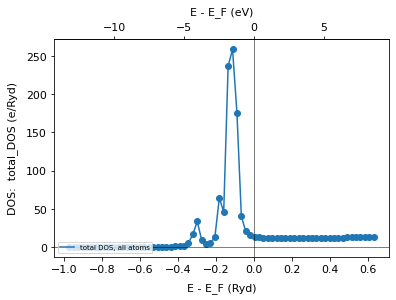

In [11]:
#to use this basic plotting tool, first a Dict node has to 
plot_DOS_atoms(scf_calc.outputs.result, "total_DOS", allatomsDOS=True)

As the two atoms are equivalent in the fcc structure, one expects their individual DOSs to be identical. Let's check this:

atom 1 Cu
atom 2 Cu


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='E - E_F (Ryd)', ylabel='DOS:  total_DOS (e/Ryd)'>)

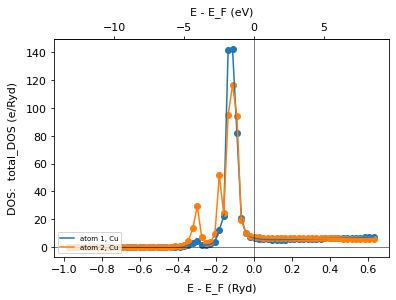

In [12]:
plot_DOS_atoms(scf_calc.outputs.result, "total_DOS")

Well, this at least looks similar, maybe the temperature or the number of energy points has to be increased. Also the Fermi level seems to be off (as Cu is a conductor obviously, so it should lie at non-zero DOS).
We can see the contribution of s-like and p-like orbitals.

atom 1 Cu
atom 2 Cu


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='E - E_F (Ryd)', ylabel='DOS:  s (e/Ryd)'>)

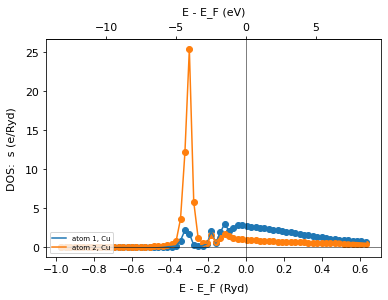

In [13]:
plot_DOS_atoms(scf_calc.outputs.result, "s")

atom 1 Cu
atom 2 Cu


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='E - E_F (Ryd)', ylabel='DOS:  d (e/Ryd)'>)

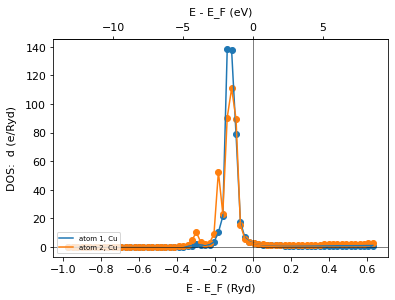

In [14]:
plot_DOS_atoms(scf_calc.outputs.result, "d")